# Part 3: Data Analytics - Spotify

This project will attempt to examine how music has changed over time, as well as how different audio features affect the current popularity of a song.

To achieve this, data will be obtained from the Spotify web API via the Spotipy Python library.

To obtain the data, Spotify Developer was connected to my spotify account, and a client ID created.

Using the obtained client ID and secret ID to authenticate credentials, data can be queried from the Spotify API's endpoints.

In [107]:
# Run the latest version of Spotipy

pip install spotipy --upgrade

SyntaxError: invalid syntax (<ipython-input-107-b7e99a4376cc>, line 3)

In [90]:
# Import libraries

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
#import time 

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

In [212]:
# ipython magic command:
# This line loads matplotlib package for ipython notebook 
# and configures matplotlib to show figures embedded in the notebook, 
# instead of poping up a new window. 
%matplotlib inline

In [170]:
# url = 'spotify.com'
# r = requests.get(url)

# r.status_code #200 means okay

In [105]:
# Authenticate client credentials flow to allow access to data

SPOTIPY_CLIENT_ID = '6707ce712ade4311b1970b5676fb226e'
SPOTIPY_CLIENT_SECRET = '7f4a7afd967f4c39aa88d8a55dfa4a94'

client_credentials_manager = SpotifyClientCredentials(SPOTIPY_CLIENT_ID, SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### Step 1: Crawl a real-world dataset

#### Data Collection

Having authenticated the credentials, the next step was to actually retrieve the data.

To do this, a function was created that uses the search endpoint of the Spotify API. This takes a query value to search for, which can take many forms such as artist or album name, song title, or year of release. Additionally a type can be specified for further granularity, as well as a limit on the number of search results, which has a default maximum of 50. The search endpoint returns various kinds of data on the query. As the primary aim of the project was to examine changes in music over time, the query was configured to return songs by the inputted year of release. 

The function uses a for loop and the offset argument to the search endpoint to work around the 50 result limit, returning 1000 results per query. The query results were then reduced to just the required variables, which are summarised as follows:


- Artist - The artist who released the song.
- Song - The name of the song.
- Popularity - The popularity of a song, given a value between 0-100 where 100 is the most popular.
- Release Date - The date of the first release of the album containing the song.
- Song Length - The song length in milliseconds.
- Explicit - Whether the song has explicit lyrics. False means it does not or it is unknown.
- Track ID - The ID associated with the song.

Next, function combines the required variables into a pandas data frame, sorting the results by popularity and reducing it to the top 50 songs.




After this, the audio features from eack song were retrieved, using the track ids from the search query as an argument.

The audio features metrics are defined by Spotify as follows:

- Acousticness - A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
<br>
- Danceability - Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
<br>
- Energy - A measure from 0.0 to 1.0 and representing a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
<br>
- Instrumentalness - Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
<br>
- Key - The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
<br>
- Liveness - Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
<br>
- Loudness - The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
<br>
- Mode - Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
<br>
- Speechiness - Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
<br>
- Tempo - The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
<br>
- Time Signature - An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4". 
<br>

- Valence - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).




Finally, the song information and song audio features data frames are merged together.



In [189]:
def get_years_top_songs(years):
    
    artist = []
    track_name = []
    track_id = []
    release_date = []
    track_length = []
    explicit = []
    popularity = []
    
    for i in range(0, 1000, 50):
        years_songs = sp.search(q='year:' + years, type='track', limit = 50, offset = i)


        for item in years_songs['tracks']['items']:
            #print(i,track)
            #print(track['artists'][0])
            artist.append(item['artists'][0]['name'])
            track_name.append(item['name'])
            track_id.append(item['id'])
            release_date.append(item['album']['release_date'])
            track_length.append(item['duration_ms'])
            explicit.append(item['explicit'])
            popularity.append(item['popularity'])
            
            
    #songs_base_info = [artist, track_name, track_id, release_date, track_length, explicit, popularity]
    
    songs_base_info = pd.DataFrame({'decade' : years,
                                    'artist' : artist,
                                    'song' : track_name,
                                    'track id' : track_id,
                                    'release date' : release_date,
                                    'song length (ms)' : track_length,
                                    'explicit' : explicit,
                                    'popularity' : popularity})
    
    base_info_top_50 = songs_base_info.sort_values('popularity', ascending = False).head(50)

    acousticness = []
    danceability = []
    energy = []
    instrumentalness = []
    key = []
    liveness = []
    loudness = []
    mode = []
    speechiness = []
    tempo = []
    time_signature = []
    valence = []

    
    # Retrieve audio features of each of the top 50 songs in the given decade
    
    track_id = base_info_top_50['track id']  

    for song_id in track_id:

        song_features = sp.audio_features(song_id) # POSSIBLY CHANGE TO PROVIDE ALL ID'S AT ONCE

        # features
        acousticness.append(song_features[0]['acousticness'])
        danceability.append(song_features[0]['danceability'])
        energy.append(song_features[0]['energy'])
        instrumentalness.append(song_features[0]['instrumentalness'])
        key.append(song_features[0]['key'])
        liveness.append(song_features[0]['liveness'])
        loudness.append(song_features[0]['loudness'])
        mode.append(song_features[0]['mode'])
        speechiness.append(song_features[0]['speechiness'])
        tempo.append(song_features[0]['tempo'])
        time_signature.append(song_features[0]['time_signature'])
        valence.append(song_features[0]['valence'])

#     songs_audio_info = [acousticness, danceability, energy, instrumentalness, liveness, 
#                        loudness, mode, speechiness, tempo, time_signature, valence]
    
    songs_audio_info = pd.DataFrame({'track id' : track_id,
                                     'acousticness' : acousticness,
                                     'danceability' : danceability,
                                     'energy' : energy,
                                     'instrumentalness' : instrumentalness,
                                     'key' : key,
                                     'liveness' : liveness,
                                     'loudness' : loudness,
                                     'mode' : mode,
                                     'speechiness' : speechiness,
                                     'tempo' : tempo,
                                     'time signature' : time_signature,
                                     'valence' : valence})
    
    
#     extend = songs_base_info.extend(songs_audio_info)

    # Combine base info with audio features info by merging on track ID

    songs = pd.merge(base_info_top_50, songs_audio_info)
    
    
    return songs


In [81]:
#a = get_years_top_songs('2009')

#a

In [82]:
# a.info()

Each individual decade is then brought together into the same data frame, and written to a csv file.

In [190]:
def concat_decades(decades):
    
    decades_top_songs_list = []

    for decade in decades:
        
        top_50_decade_songs = get_years_top_songs(decade)
        
        decades_top_songs_list.append(top_50_decade_songs)
        
    decades_final = pd.concat(decades_top_songs_list)
    
    
    return decades_final
        
        
    

In [191]:
decades = ["1900-1909",
           "1910-1919",
           "1920-1929",
           "1930-1939",
           "1940-1949",
           "1950-1959",
           "1960-1969",
           "1970-1979",
           "1980-1989",
           "1990-1999",
           "2000-2009",
           "2010-2019",
           "2020-2029"]

decades_dataset = concat_decades(decades)

#decades_dataset

# Export data frame as csv

decades_dataset.to_csv("decades_dataset.csv", sep = ',')

The main variable of interest is the popularity metric and the decade of the song.

By examining the popularity metric in combination with the audio features of each song, as well as its length and if it is explicit, any relationships and correlations between these will be found.

Additionally, will look at how the current most popular songs from each decade vary with each of the audio features.

### STEP 2: Perform data preparation & cleaning

#### Data preparation & cleaning

Need to explore the number of rows and columns, ranges of values etc.

Handle missing data, if any

Perform any additional steps (parsing dates, creating additional columns, etc)

In [61]:
# Load the dataset into a dataframe using Pandas

dataset = pd.read_csv('decades_dataset.csv')

#dataset

Initial observations from looking at the dataset:

- Index from each csv has been read as first column - this is the decade rank (out of 50) of a song, but starts at 0 rather than 1.
- Song length in milliseconds makes little sense, would be easier to understand in minutes.
- Key, mode and time signature are nominal categorical variables - their given value does not represent anything numerically.
- Some modern songs in '1900-1909' decade appear to have wrongly been given release date at start of century.
- As popularity is based on current playtime, many christmas songs featured, particularly in older decades.

In [62]:
# Rename the columns to reflect the desired changes
dataset.rename(
    columns={
        'Unnamed: 0' : 'decade rank',
        'song length (ms)' : 'song length (mins)'
    }, inplace=True)


In [63]:
dataset['song length (mins)'] = (dataset['song length (mins)']/1000)/60

dataset['decade rank'] = dataset['decade rank'] + 1

dataset



,decade rank,decade,artist,song,track id,release date,song length (mins),explicit,popularity,acousticness,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time signature,valence
0,1,1900-1909,Frédéric Chopin,"Chopin: Piano Sonata No. 2 in B-Flat Minor, Op...",4tDa5P1so01pdVc5Ywl6Or,1900,9.966000,False,45,0.99300,...,0.00189,0.919000,1,0.0955,-28.565,1,0.0487,93.131,4,0.153
1,2,1900-1909,Peter Gabriel,Sledgehammer,3wLZ69kr5J2sb934Kpv02c,1900,4.927550,False,44,0.03510,...,0.62000,0.000000,8,0.1530,-8.146,1,0.0293,96.392,4,0.626
2,3,1900-1909,Henry Purcell,"Purcell / Arr. Pluhar: Oedipus, Z. 583: No. 2,...",2UK3kMSQc8fMTCjEykifQ7,1900,5.905550,False,44,0.96300,...,0.04530,0.037800,5,0.0989,-23.319,0,0.0377,136.925,4,0.120
3,4,1900-1909,Horkýže Slíže,A ja sprostá,1tRUTDC96dxQv8truEHmmM,1900,2.966000,True,42,0.03780,...,0.94700,0.000020,9,0.2850,-3.032,1,0.0503,142.063,4,0.755
4,5,1900-1909,Los Carrangueros De Ráquira,La China Que Yo Tenia,5q5YkZJxosN5pPCU42TKo3,1905-06-02,4.454300,False,42,0.73200,...,0.39600,0.000000,5,0.0562,-10.663,1,0.0449,122.778,4,0.961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,46,2020-2029,Tiësto,Don't Be Shy,0bI7K9Becu2dtXK1Q3cZNB,2021-08-12,2.341667,True,91,0.19800,...,0.78700,0.000000,11,0.2620,-3.748,0,0.0583,119.986,4,0.513
646,47,2020-2029,Drake,Knife Talk (with 21 Savage ft. Project Pat),2BcMwX1MPV6ZHP4tUT9uq6,2021-09-03,4.049417,True,90,0.06350,...,0.42400,0.000000,5,0.0834,-9.579,0,0.3240,145.887,4,0.153
647,48,2020-2029,Justin Bieber,Ghost,6I3mqTwhRpn34SLVafSH7G,2021-03-19,2.553167,False,90,0.18500,...,0.74100,0.000029,2,0.4150,-5.569,1,0.0478,153.960,4,0.441
648,49,2020-2029,Måneskin,I WANNA BE YOUR SLAVE,4pt5fDVTg5GhEvEtlz9dKk,2021-03-19,2.889100,True,90,0.00165,...,0.60800,0.000000,1,0.1780,-4.008,1,0.0387,132.507,4,0.958


In [85]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 50 to 649
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   decade rank         600 non-null    int64   
 1   decade              600 non-null    object  
 2   artist              600 non-null    object  
 3   song                600 non-null    object  
 4   track id            600 non-null    object  
 5   release date        600 non-null    object  
 6   song length (mins)  600 non-null    float64 
 7   explicit            600 non-null    bool    
 8   popularity          600 non-null    int64   
 9   acousticness        600 non-null    float64 
 10  danceability        600 non-null    float64 
 11  energy              600 non-null    float64 
 12  instrumentalness    600 non-null    float64 
 13  key                 600 non-null    category
 14  liveness            600 non-null    float64 
 15  loudness            600 non-null    flo

Need to change key, mode and time signature to categorical variables.

In [66]:
dataset['key'] = dataset['key'].astype('category')

In [68]:
dataset['mode'] = dataset['mode'].astype('category')

In [70]:
dataset['time signature'] = dataset['time signature'].astype('category')

In [88]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 50 to 649
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   decade rank         600 non-null    int64   
 1   decade              600 non-null    object  
 2   artist              600 non-null    object  
 3   song                600 non-null    object  
 4   track id            600 non-null    object  
 5   release date        600 non-null    object  
 6   song length (mins)  600 non-null    float64 
 7   explicit            600 non-null    bool    
 8   popularity          600 non-null    int64   
 9   acousticness        600 non-null    float64 
 10  danceability        600 non-null    float64 
 11  energy              600 non-null    float64 
 12  instrumentalness    600 non-null    float64 
 13  key                 600 non-null    category
 14  liveness            600 non-null    float64 
 15  loudness            600 non-null    flo

In [72]:
dataset['decade'].value_counts()

1900-1909    50
1910-1919    50
1920-1929    50
1930-1939    50
1940-1949    50
1950-1959    50
1960-1969    50
1970-1979    50
1980-1989    50
1990-1999    50
2000-2009    50
2010-2019    50
2020-2029    50
Name: decade, dtype: int64

In [339]:
# dataset.describe()

We now look at the 1900-1909 decade in detail to examine what is going on with release date.

In [73]:
first_decade = dataset[dataset['decade'] == '1900-1909'] 

first_decade

,decade rank,decade,artist,song,track id,release date,song length (mins),explicit,popularity,acousticness,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time signature,valence
0,1,1900-1909,Frédéric Chopin,"Chopin: Piano Sonata No. 2 in B-Flat Minor, Op...",4tDa5P1so01pdVc5Ywl6Or,1900,9.966000,False,45,0.993000,...,0.00189,0.919000,1,0.0955,-28.565,1,0.0487,93.131,4,0.1530
1,2,1900-1909,Peter Gabriel,Sledgehammer,3wLZ69kr5J2sb934Kpv02c,1900,4.927550,False,44,0.035100,...,0.62000,0.000000,8,0.1530,-8.146,1,0.0293,96.392,4,0.6260
2,3,1900-1909,Henry Purcell,"Purcell / Arr. Pluhar: Oedipus, Z. 583: No. 2,...",2UK3kMSQc8fMTCjEykifQ7,1900,5.905550,False,44,0.963000,...,0.04530,0.037800,5,0.0989,-23.319,0,0.0377,136.925,4,0.1200
3,4,1900-1909,Horkýže Slíže,A ja sprostá,1tRUTDC96dxQv8truEHmmM,1900,2.966000,True,42,0.037800,...,0.94700,0.000020,9,0.2850,-3.032,1,0.0503,142.063,4,0.7550
4,5,1900-1909,Los Carrangueros De Ráquira,La China Que Yo Tenia,5q5YkZJxosN5pPCU42TKo3,1905-06-02,4.454300,False,42,0.732000,...,0.39600,0.000000,5,0.0562,-10.663,1,0.0449,122.778,4,0.9610
5,6,1900-1909,Roy Brown,Mighty Mighty Man,5tBDBrsPypLVJ9Rbpy3MNm,1900-01-30,2.387167,False,42,0.824000,...,0.37400,0.000000,0,0.5810,-15.127,0,0.0392,106.456,4,0.8200
6,7,1900-1909,Royal Bliss,I Was Drunk,1SbSX9AWecOf7v0CFTHZ4Q,1900,4.064000,False,41,0.003000,...,0.46200,0.000000,1,0.3130,-9.165,1,0.0304,187.510,3,0.2610
7,8,1900-1909,Los Carrangueros De Ráquira,La Cucharita,2EP7binVbGE0KS15sQ62cn,1905-06-02,3.991933,False,40,0.838000,...,0.59200,0.000000,7,0.0638,-7.485,1,0.0397,112.866,4,0.8850
8,9,1900-1909,ABSOLUT TIROL,Rosi Polka,2GTzHDJxwvHWEL9TYD8NCx,1905-06-10,3.100433,False,38,0.265000,...,0.92600,0.864000,5,0.0696,-2.820,1,0.0437,125.090,4,0.9640
9,10,1900-1909,La Decada Prodigiosa,Una Fiesta Especial (Remix),0iJkGv6xNDKjMyBlcC2OQN,1900,5.873767,False,38,0.006340,...,0.95200,0.043800,10,0.3510,-7.595,1,0.0409,136.806,4,0.8790


In [74]:
first_decade['release date'].value_counts()

1900          23
1900-01-01    10
1905-06-10     4
1905-06-02     3
1900-01-30     3
1908-08-01     2
1900-01-29     1
1900-01-06     1
1909           1
1909-06-19     1
1905-08-07     1
Name: release date, dtype: int64

In [75]:
first_decade[first_decade['artist'] == 'Peter Gabriel']['release date'].value_counts()

1900    4
Name: release date, dtype: int64

Looking at the value count from the release date variable for just the first decade, we can see that only 17 songs from the decade do not have the release date of the first of january 1900, or just the year 1900.

Further examination of the artists given with this decade reveal names such as Peter Gabriel, singer of the progressive rock band Genesis in the 1970's, all of whose songs in the data frame have the release date 1900. \

Subsequently, it appears safe to assume that the majority, if not all, of the songs with this release date, or 01/01/1900, are incorrect. As this makes up 33 out of 50 rows for this date, the decision is made to remove the decade from the data.

In [76]:
dataset.shape

(650, 21)

In [77]:
# Drop the 1900-1909 decade from the dataset

dataset = dataset[dataset['decade'] != '1900-1909']

In [78]:
# Confirm 50 rows removed

dataset.shape

(600, 21)

In [28]:
#dataset

Next, we need to account for the fact that songs can appear on different albums, which are considered independent in the Spotify search endpoint. Subsequently, we try to identify which songs are duplicated.

In [79]:
# group the entries by artist_name and track_name and check for duplicates

grouped = dataset.groupby(['artist','song'], as_index=True).size()
#grouped[grouped > 1].count()

grouped[grouped > 1]

artist                    song                                                                
Adele                     Easy On Me                                                              2
Bing Crosby               White Christmas                                                         2
Doris Day                 Here Comes Santa Claus (Down Santa Claus Lane)                          2
Frank Sinatra             Let It Snow! Let It Snow! Let It Snow! (with The B. Swanson Quartet)    2
Fred Astaire              Cheek to Cheek                                                          2
Harry James               It's Been a Long, Long Time                                             2
Lil Nas X                 INDUSTRY BABY (feat. Jack Harlow)                                       2
The Dave Brubeck Quartet  Take Five                                                               2
The Kid LAROI             STAY (with Justin Bieber)                                               2
Tony 

There are 10 duplicate rows in the data, which feature exactly the same artist and song combination. We subset the data frame to Adele songs to examine the duplicates further.

In [80]:
dataset[dataset['artist'] == 'Adele']

,decade rank,decade,artist,song,track id,release date,song length (mins),explicit,popularity,acousticness,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time signature,valence
602,3,2020-2029,Adele,Easy On Me,0gplL1WMoJ6iYaPgMCL0gX,2021-10-14,3.744900,False,98,0.578,...,0.366,0.0,5,0.1330,-7.519,1,0.0282,141.981,4,0.13
626,27,2020-2029,Adele,Oh My God,3Kkjo3cT83cw09VJyrLNwX,2021-11-19,3.752467,False,93,0.091,...,0.725,0.0,1,0.0264,-3.906,1,0.0460,88.098,4,0.55
637,38,2020-2029,Adele,Easy On Me,46IZ0fSY2mpAiktS3KOqds,2021-11-19,3.744900,False,92,0.578,...,0.366,0.0,5,0.1330,-7.519,1,0.0282,141.981,4,0.13


We now see that duplicate songs are identical in all aspects other than release date and popularity. As this is unlikely to affect analysis, it is left for now.

In [33]:
#drop_duplicates

Findings: 

- The dataset has 21 columns and 600 rows, with 50 rows from each of 12 decades after the removal of 1900-1909.
- There are no missing values in any columns.
- Provisionally, no additional columns are needed.
- Key, mode and time signature are nominal data so encoded as numbers to represent the categories
- All other audio features are continuous variables.
- Acousticness, danceabiity, energy, instrumentalness, liveness, speechiness and valence are calculated continuous variables, ranging from 0-1.
- Loudness (db) and tempo (bpm) are measured continuous variables.


### Step 3: Perform exploratory analysis and ask questions

#### Exploratory analysis

TASK - Explore your data, examples are as follows:
- Compute the mean, sum, range and other interesting statistics for numeric columns.
- Explore distributions of numeric columns using histograms etc.
- Explore the relationship between columns using scatter plots, bar charts, etc.

**Categorical variables EDA**

In [86]:
dataset['explicit'].value_counts()

False    541
True      59
Name: explicit, dtype: int64

In [87]:
dataset['key'].value_counts() #0 = C, 1 = C#/D, 2=D, etc

0     81
7     60
9     60
2     57
5     57
1     53
8     48
10    47
4     40
3     36
11    32
6     29
Name: key, dtype: int64

In [36]:
#The modality (major or minor) of a track, the type of scale from which its melodic content is derived. 
#Major is represented by 1 and minor is 0.
dataset['mode'].value_counts()

1    444
0    156
Name: mode, dtype: int64

In [37]:
dataset['time signature'].value_counts() #how much beats in each bar (or measure)

4    528
3     55
5     12
1      5
Name: time signature, dtype: int64

**Numeric variables EDA**

In [83]:
#dataset.describe(include = 'all')

dataset.describe()

,decade rank,song length (mins),popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,600.00000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,25.50000,3.508369,68.746667,0.537124,0.571937,0.472257,0.080704,0.186580,-10.325220,0.067187,120.356548,0.557179
std,14.44291,1.341011,24.361410,0.376657,0.171614,0.266854,0.225239,0.146065,4.998935,0.067086,31.909163,0.256558
min,1.00000,0.826217,6.000000,0.000025,0.111000,0.005250,0.000000,0.026400,-37.783000,0.023200,46.718000,0.047600
25%,13.00000,2.800408,55.000000,0.128750,0.465750,0.239750,0.000000,0.094900,-13.100500,0.034675,94.456000,0.352000
50%,25.50000,3.249217,80.000000,0.604500,0.588500,0.456500,0.000053,0.128500,-9.967500,0.043150,117.748500,0.577000
75%,38.00000,3.959325,85.000000,0.917000,0.699250,0.704250,0.004395,0.239750,-6.512750,0.062100,139.996000,0.776250
max,50.00000,20.656667,100.000000,0.996000,0.951000,0.981000,0.962000,0.881000,-1.538000,0.419000,207.975000,0.979000


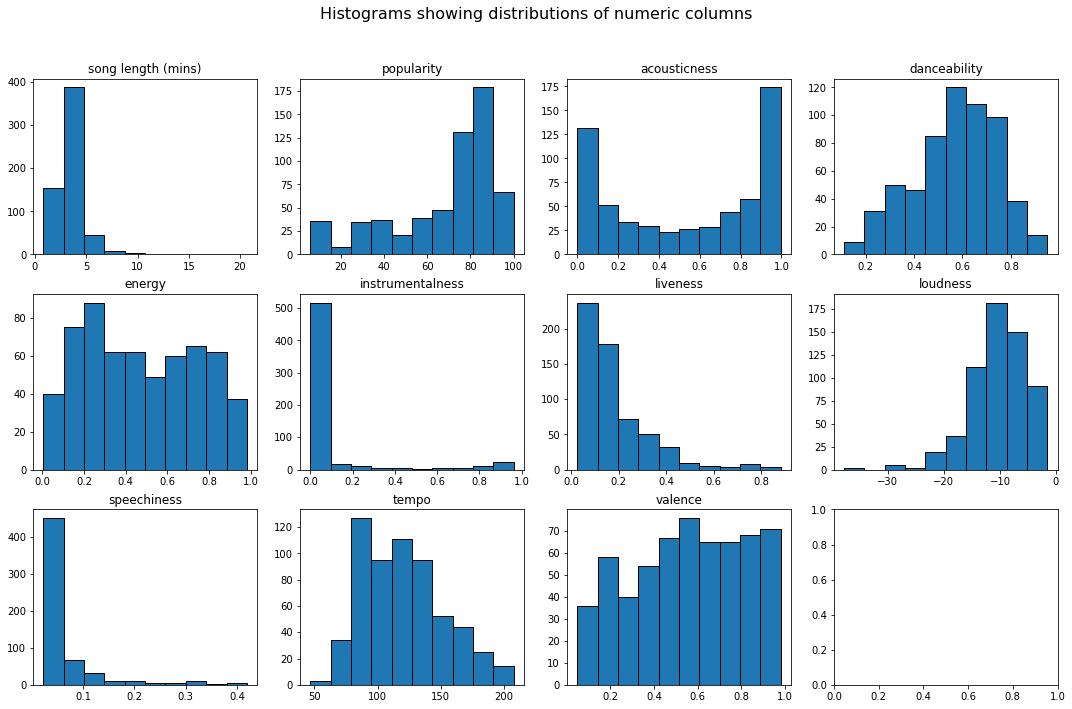

In [104]:
titles = ['song length (mins)','popularity','acousticness','danceability', 'energy',
         'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'] 

fig, ax = plt.subplots(3, 4, figsize = (15,10))
ax[0, 0].hist(dataset['song length (mins)'], edgecolor = 'black'), ax[0, 0].title.set_text('song length (mins)')
ax[0, 1].hist(dataset['popularity'], edgecolor = 'black'), ax[0, 1].title.set_text('popularity')
ax[0, 2].hist(dataset['acousticness'], edgecolor = 'black'), ax[0, 2].title.set_text('acousticness')
ax[0, 3].hist(dataset['danceability'], edgecolor = 'black'), ax[0, 3].title.set_text('danceability')
ax[1, 0].hist(dataset['energy'], edgecolor = 'black'), ax[1, 0].title.set_text('energy')
ax[1, 1].hist(dataset['instrumentalness'], edgecolor = 'black'), ax[1, 1].title.set_text('instrumentalness')
ax[1, 2].hist(dataset['liveness'], edgecolor = 'black'), ax[1, 2].title.set_text('liveness')
ax[1, 3].hist(dataset['loudness'], edgecolor = 'black'), ax[1, 3].title.set_text('loudness')
ax[2, 0].hist(dataset['speechiness'], edgecolor = 'black'), ax[2, 0].title.set_text('speechiness')
ax[2, 1].hist(dataset['tempo'], edgecolor = 'black'), ax[2, 1].title.set_text('tempo')
ax[2, 2].hist(dataset['valence'], edgecolor = 'black'), ax[2, 2].title.set_text('valence')
ax[2, 3]

fig.tight_layout()

plt.suptitle("Histograms showing distributions of numeric columns", size = 16)

fig.subplots_adjust(top=0.88)

#plt.show()

Observations:
- There is a very long song of over 20 minutes, could remove as an outlier
- Acousticness is often very high or very low
- Instrumentalness and liveliness are mostly very low (less than 0.2)
- There is a very loud song (almost -40 decibels), could be an outlier
- Average speechiness is less than 0.1, and maximum only 0.4. Not much variability.
- Valence is pretty equally distributed, slightly more positive than negative

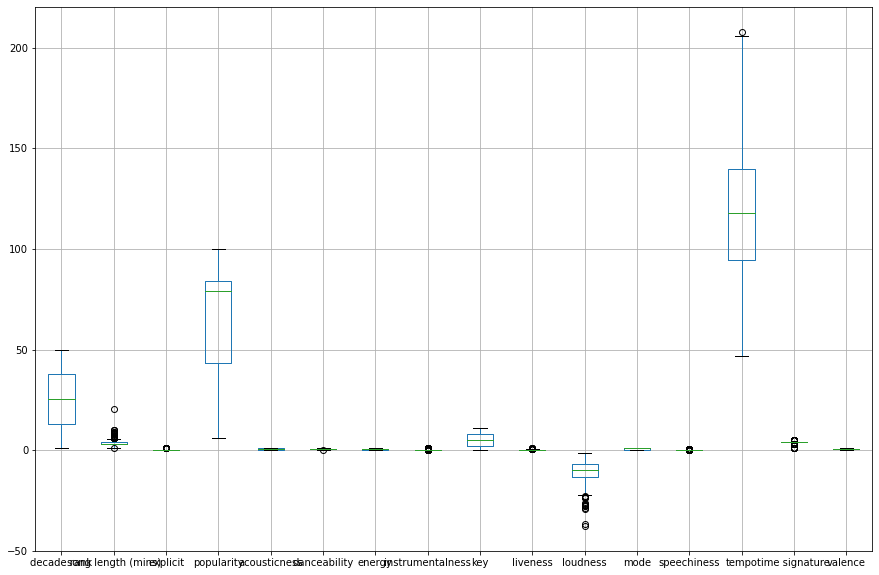

In [328]:
_, bp = pd.DataFrame.boxplot(dataset, return_type = 'both', figsize = (15, 10))

This appears to support the observation from the histograms, with most significant outliers in song length and loudness. Lets examine each boxplot in greater detail.

In [329]:
outliers = [flier.get_ydata() for flier in bp["fliers"]] #fliers = points outside whiskers

#outliers

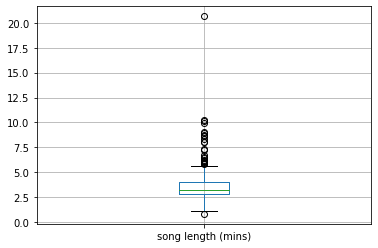

In [335]:
bp = dataset.boxplot(column='song length (mins)')

Can see in the boxplot for song length that there are a number of longer songs towards ten minutes, but one extremely long song at over 20 minutes. To Check this we look at songs over 7 and a half minutes in the data frame.

In [331]:
dataset[dataset['song length (mins)'] > 7.5] 

,decade rank,decade,artist,song,track id,release date,song length (mins),explicit,popularity,acousticness,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time signature,valence
0,1,1900-1909,Frédéric Chopin,"Chopin: Piano Sonata No. 2 in B-Flat Minor, Op...",4tDa5P1so01pdVc5Ywl6Or,1900,9.966000,False,45,0.9930,...,0.00189,0.9190,1,0.0955,-28.565,1,0.0487,93.131,4,0.1530
52,3,1910-1919,Ludwig van Beethoven,"Violin Sonata in A Major No. 9, Op. 47 ""Kreutz...",1Nlajo81JRjPyan1lj0k3I,1917,10.103767,False,28,0.9730,...,0.19900,0.4380,9,0.0396,-14.454,0,0.0589,79.513,4,0.1360
56,7,1910-1919,Ludwig van Beethoven,"Violin Concerto in D Major, Op. 61: II. Larghetto",737JkPjECdA6ovDB2tVyzS,1917,8.754667,False,24,0.8100,...,0.04460,0.0702,7,0.3620,-29.453,1,0.0452,100.963,4,0.0476
57,8,1910-1919,Ludwig van Beethoven,"Violin Concerto in D Major, Op. 61: III. Rondo...",6KnRJ01itdWnLAwjZRUi8T,1917,8.365550,False,24,0.8700,...,0.09130,0.1710,2,0.2160,-20.861,1,0.0427,94.354,4,0.4080
58,9,1910-1919,Ludwig van Beethoven,"Violin Concerto in D Major, Op. 61: I. Allegro...",7bPfZ6VVhZASf5Aljm6NMn,1917,20.656667,False,24,0.8800,...,0.09590,0.0424,2,0.0877,-21.114,1,0.0422,106.647,4,0.1890
90,41,1910-1919,Ludwig van Beethoven,"Romance No. 2, Op. 50, in F",6ruwzUYQU825uM54dNnTAb,1917,7.994000,False,7,0.8760,...,0.21500,0.1980,5,0.2590,-14.495,1,0.0389,104.856,4,0.1430
102,3,1920-1929,Benny Goodman,"Sing, Sing, Sing",61znp1Iy11bdJ2YAbwaqw7,1928,8.668883,False,52,0.8470,...,0.74400,0.8920,2,0.1450,-9.189,0,0.0662,113.117,4,0.2590
163,14,1930-1939,Franz Liszt,"Hungarian Rhapsody No. 2 in C-Sharp Minor, S. ...",7CIoJE0JfVFcmmUY3fFojH,1930,9.026667,False,48,0.9870,...,0.32600,0.8860,1,0.7840,-15.347,1,0.0551,80.233,4,0.1680
365,16,1970-1979,Led Zeppelin,Stairway to Heaven - Remaster,5CQ30WqJwcep0pYcV4AMNc,1971-11-08,8.047167,False,82,0.5800,...,0.34000,0.0032,9,0.1160,-12.049,0,0.0339,82.433,4,0.1970
394,45,1970-1979,Don McLean,American Pie,1fDsrQ23eTAVFElUMaf38X,1971,8.614883,False,78,0.6990,...,0.48100,0.0000,4,0.0842,-11.709,0,0.0600,138.450,4,0.4910


Can now see that the majority of songs over 7 and a half minutes are from the early 20th century, with several from the very famous classical composer Beethoven. Longer songs are not uncommon in classical music so we are happy to these are not mistakes and keep them in the analysis.

This does, however, bring up a separate observation which is that Beethoven died in the early 19th century, and so the release must have been posthumous.

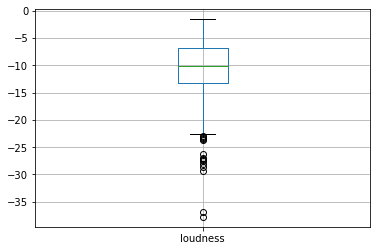

In [337]:
bp = dataset.boxplot(column='loudness')
# Sometimes you have to force display of outliers:
#bp = plt.boxplot(dataset.loudness, 0, 'ro') # red circle

The boxplot for loudness confirms that there are a number of outliers over 25 decibels, but in particular there is in fact two over 25. Again, to examine this in detail we subset the database to those over 25 decibels.


In [338]:
dataset[dataset['loudness'] < -25] 

,decade rank,decade,artist,song,track id,release date,song length (mins),explicit,popularity,acousticness,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time signature,valence
0,1,1900-1909,Frédéric Chopin,"Chopin: Piano Sonata No. 2 in B-Flat Minor, Op...",4tDa5P1so01pdVc5Ywl6Or,1900,9.966000,False,45,0.993,...,0.00189,0.919000,1,0.0955,-28.565,1,0.0487,93.131,4,0.1530
29,30,1900-1909,Franz Liszt,"Liszt: 3 Liebesträume, S. 541: No. 3 in A-Flat...",5IemwZJmPgbOYwbuSE0set,1900,5.050667,False,32,0.990,...,0.01720,0.897000,8,0.0943,-26.925,1,0.0517,114.588,4,0.0494
40,41,1900-1909,Pure Noise,Faulty Fan,7A79iQ8PdBmAgiAMB0NOtA,1900-01-01,3.283683,False,30,0.551,...,0.06020,0.742000,1,0.1110,-26.226,1,0.0747,81.440,4,0.0400
56,7,1910-1919,Ludwig van Beethoven,"Violin Concerto in D Major, Op. 61: II. Larghetto",737JkPjECdA6ovDB2tVyzS,1917,8.754667,False,24,0.810,...,0.04460,0.070200,7,0.3620,-29.453,1,0.0452,100.963,4,0.0476
66,17,1910-1919,Nikolai Rimsky-Korsakov,The Flight Of The Bumblebee,3hmPEiZ1vRCabtELE5qPNj,1919,1.161550,False,13,0.993,...,0.05070,0.743000,2,0.6360,-27.107,0,0.0596,94.853,4,0.5280
79,30,1910-1919,Christoph Willibald Gluck,Melodie,55CmzcUEhlOv2jgpRafDTB,1919,3.434000,False,9,0.989,...,0.01630,0.001820,2,0.1240,-27.609,0,0.0419,76.959,4,0.1500
87,38,1910-1919,Pyotr Ilyich Tchaikovsky,"Lullaby, Op. 16, No. 1",6pNtecp0fmzwoCBdDKifw8,1919,3.998217,False,7,0.994,...,0.03400,0.911000,8,0.1310,-27.418,0,0.0408,71.064,4,0.1310
91,42,1910-1919,Frédéric Chopin,"Nocturne in E-Flat Major, Op. 9, No. 2",1aq9cUtZijFZnoELCeBEjj,1919,4.705100,False,7,0.984,...,0.02170,0.000698,3,0.4050,-28.029,1,0.0395,104.173,4,0.1360
211,12,1940-1949,Erik Satie,Gymnopédie No. 1,5NGtFXVpXSvwunEIGeviY3,1949,3.431100,False,71,0.994,...,0.01280,0.937000,7,0.0941,-36.856,1,0.1190,72.765,3,0.3540
233,34,1940-1949,Erik Satie,Gymnopédie No. 3,0hZBK2IS2uKdWVwEWXX1vB,1949,2.923767,False,57,0.991,...,0.00766,0.873000,9,0.0732,-37.783,0,0.0975,130.918,4,0.5880


This subset again appears to show classical songs, which could reasonably be loud songs so there is no reason to remove them.

**Variables Relationships EDA**

In [141]:
#dataset[['artist', 'song']]

#df.drop(df.columns[[1, 2]], axis=1, inplace=True)

#dataset(axis = 1)

cols = [col for col in dataset.columns if col not in ['decade rank', 'explicit']]
pairplot_df = dataset[cols]

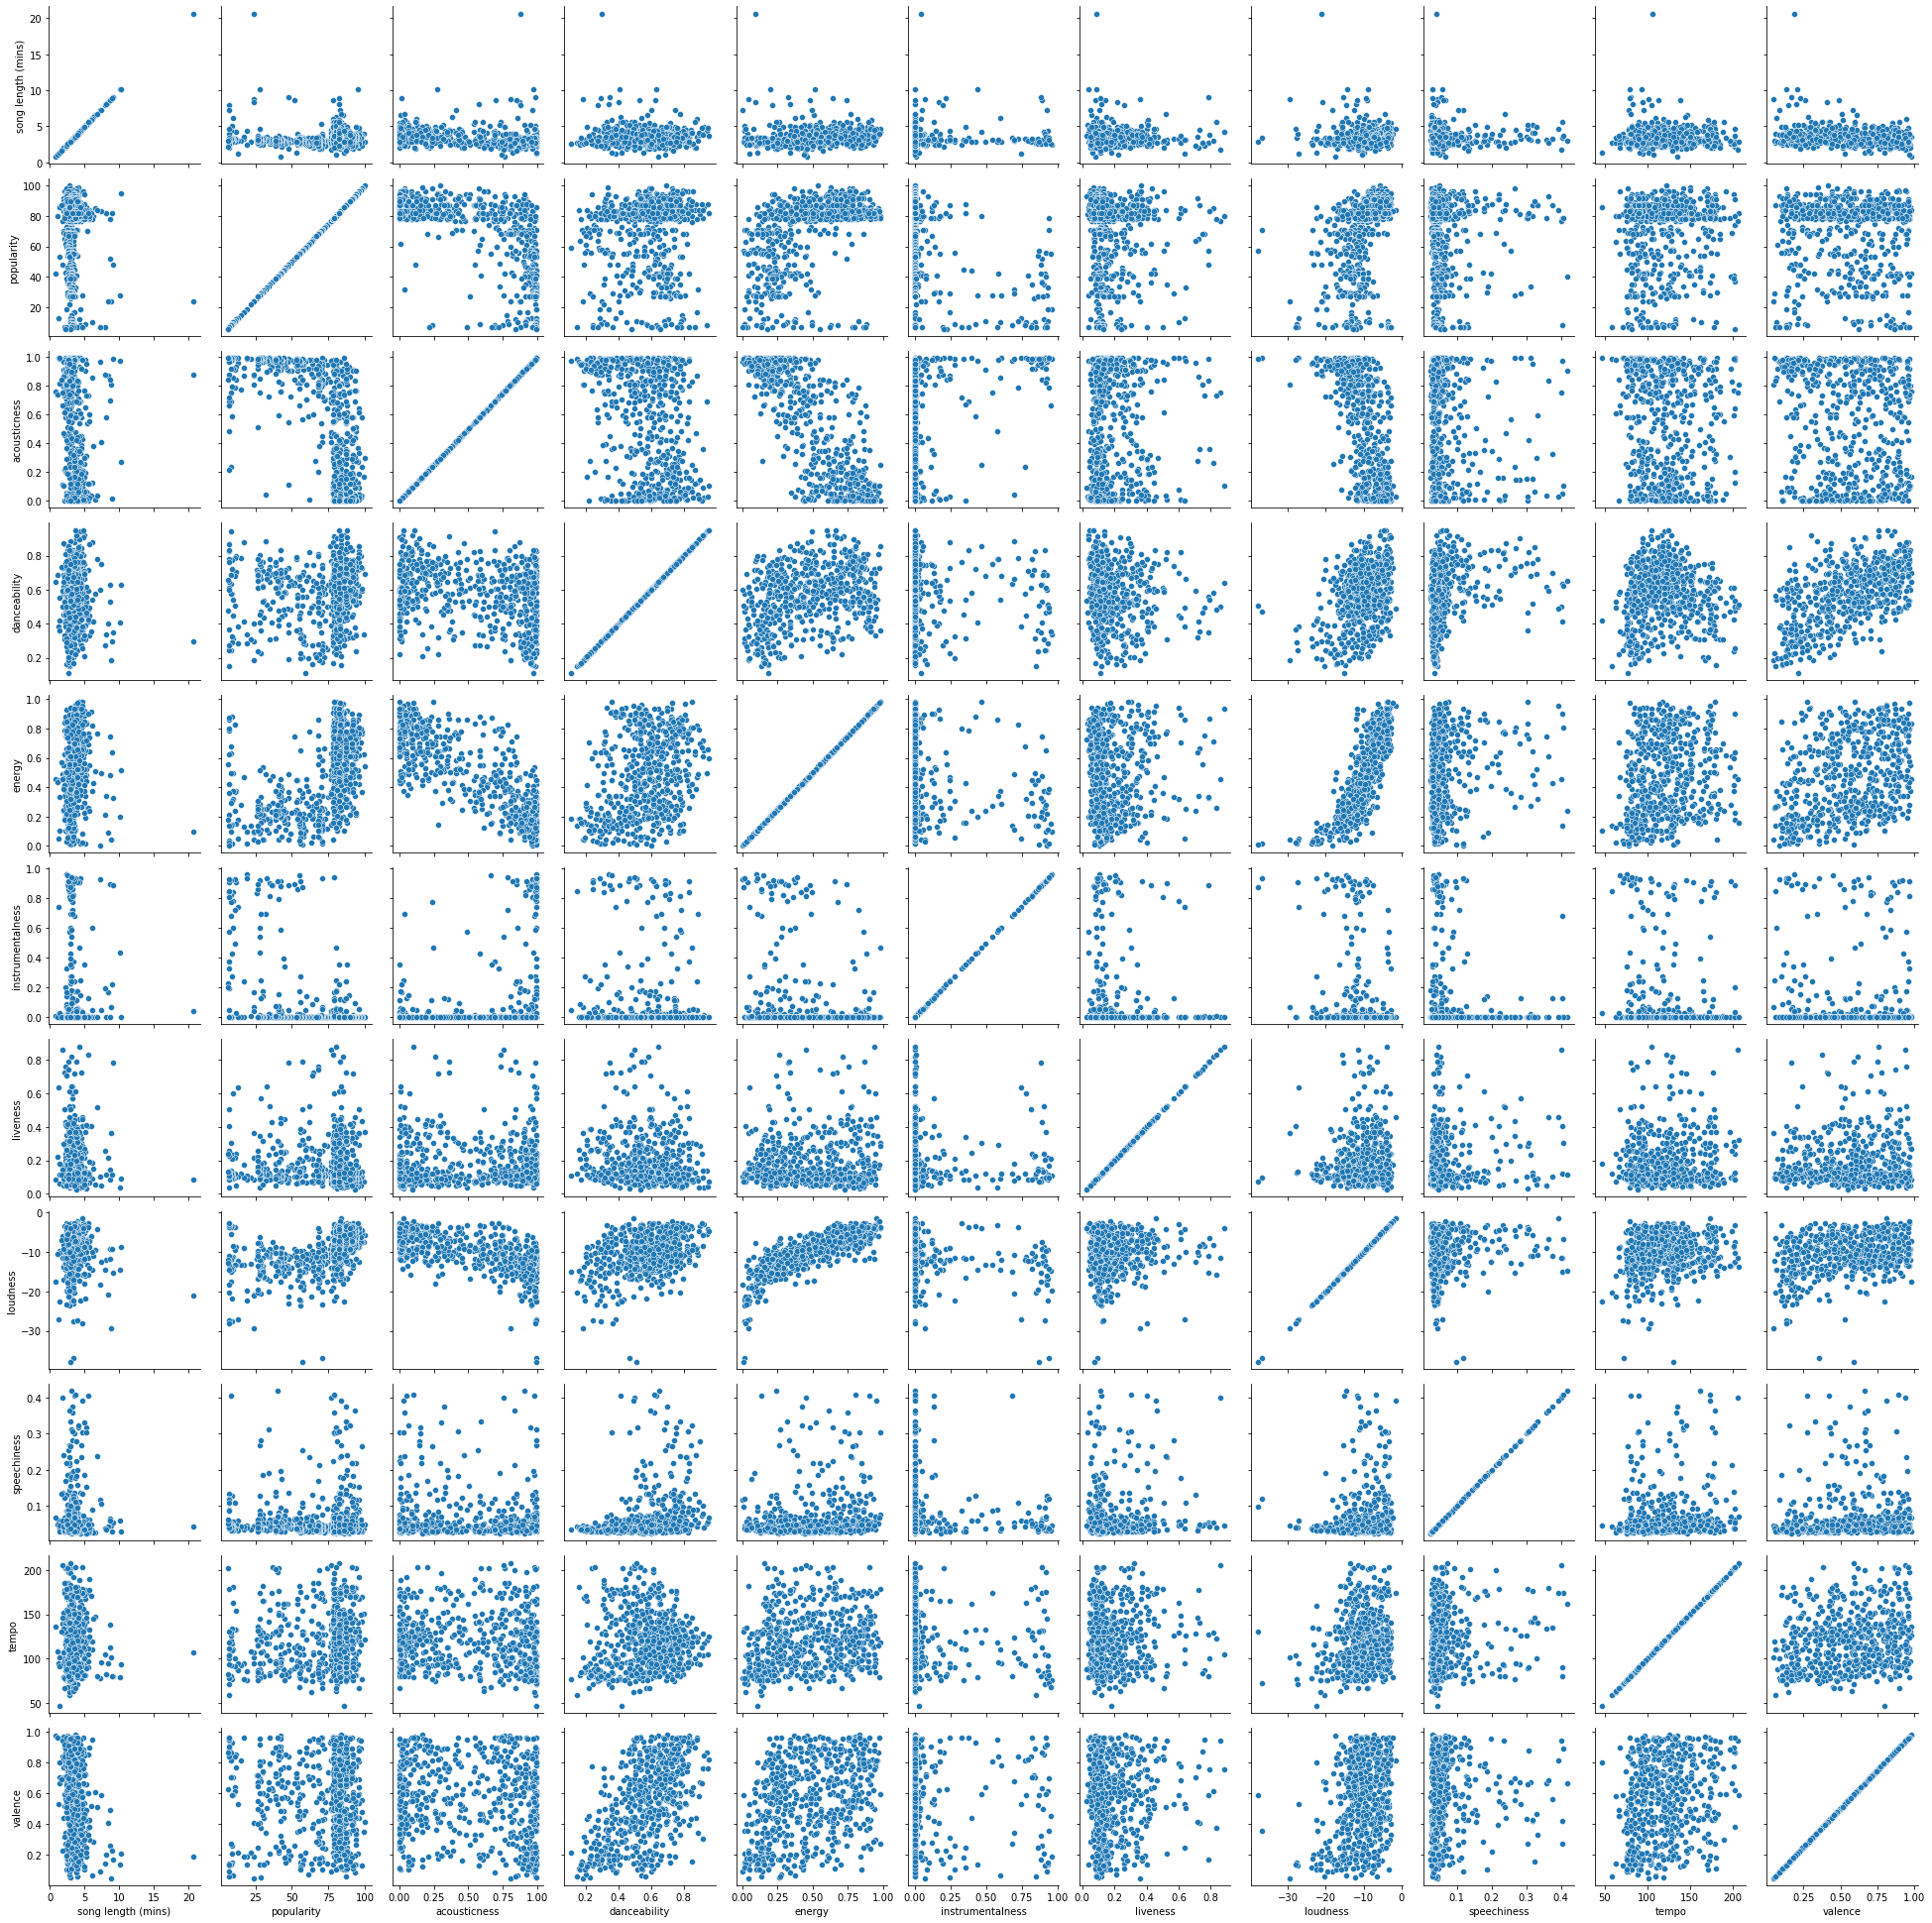

In [142]:
pairplot = sns.PairGrid(pairplot_df)


pairplot.map(sns.scatterplot)

In [112]:
pairgrid

Ask at least three interesting questions about your dataset. Your questions may have sub-questions. The quality of your questions is assessed based on the complexity and interestingness. Trivial and basic questions will not give you full marks.

**Questions:**
- Prominent shared features of the most currently popular songs from each decade
- How popularity is affected by different audio features for each decade
- What the overall most important audio features for popularity are